第四章主要内容有：
- 理解算法如何从数据中进行学习
- 使用微分和梯度下降法使得学习过程变成参数估计的过程
- 从头学习一个简单的学习算法
- 了解`PyTorch`如何支持自动求导

目前寻找模型的步骤，和很多年前科学家发现规律的流程一样。比如说开普勒发现行星运动定律，他没有计算机或者计算器，只有一些肉眼观测的数据和草稿纸，他就是不断地尝试数学模型来拟合自己手头的数据，然后观测新的数据来测试公式。和如今的深度学习如出一辙，我们目前拥有强大算力以及海量数据，更加可以找寻数据之间的规律。

# Learning is parameter estimation

学完本章，我们将熟悉使用pytorch进行机器学习或者深度学习：
1. 给定输入数据以及对应的期望输出，初始化参数
2. 将数据喂入模型， forward pass
3. 计算误差，优化函数
4. 更新参数， backward pass
5. 重复以上2~4， 直到误差达到期望范围

接下来我们引入一个小例子来完整走一遍如何训练算法找出合适的模型的过程，假设目前有一组摄氏度温度数值和一组不知道是什么单位的数据，其中两两对应，都是由同一时刻测出来的，现在我们想要找出两种不同温度测量的换算：

In [1]:
import torch
#摄氏度下的温度数据
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]

#与上面对应的另一个单位的温度数据
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]


#将以上数据转成tensor形式
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [4]:
t_c, t_u

(tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
          6.0000, 13.0000, 21.0000]),
 tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000]))

## 确定一个模型

要想知道上面两组数据的映射关系，我们因为缺乏更多的信息，所以第一步可以先假设是线性关系，也就是：

`t_c = w * t_u + b`
- w指的是weight
- b指的是bias

**注意** 我们很显然知道是线性关系，但是我们举这个例子的初衷是完整走一遍pytorch处理这类问题的流程，为的是更好的理解pytorch流程，所以就算知道了是线性关系，也请一起走一遍流程。

## 确定loss function

我们假设两组数据满足线性方程，参数包含 w 和 b, 我们需要确定一个损失函数loss function，让预测的值和ground truth的误差越来越小。

对于真实值t_c，对应的预测值是t_p， 我们需要比较两者相差多少，以便于调整模型，所以我们可以有两种方式：
1. 绝对值： `|t_c - t_p|`
2. 平方： `(t_c - t_p)^2`

## 用pytorch实现

首先实现`model` 和 `loss function`：

In [5]:
# 定义一个线性模型`t_c = w * t_u + b`
def model(t_u, w, b):
    return w * t_u + b

In [6]:
# 定义loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2     #选用平方损失函数
    return squared_diffs.mean()         #squared_diffs是一个列表，所以选择均值作为损失函数输出

我们需要初始化参数w和b：

In [9]:
w = torch.ones(1)
b = torch.zeros(1)

In [10]:
#forward pass
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [11]:
# 计算loss
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

## 计算梯度，更新参数

我们已经计算出了`loss`，如何根据`loss`更新参数`w`和`b`，从而实现`loss`最小化，就是接下来要完成的目标：

我们使用梯度下降法(Gradient descent)来更新参数：计算每个参数对loss的影响率，然后将参数朝着使得loss最小的方向变化：

我们想知道w、b的变化导致loss变化多少，所以选择看w在`(w-delta, w+delta)`范围内对loss的变化率:

In [12]:
delta = 0.1

# w+delta处的loss值减去w-delta处的函数值，再除以2倍的delta
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [13]:
learning_rate = 1e-2

#更新w
w = w - learning_rate * loss_rate_of_change_w

同理b也做同样的变化：

In [14]:
# b+delta处的loss值减去b-delta处的函数值，再除以2倍的delta
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

In [15]:
# 更新b
b = b - learning_rate * loss_rate_of_change_b

In [16]:
#更新后的w, b的值
w, b

(tensor([-44.1730]), tensor([46.0250]))

以上是逐个计算w,b对于`loss`的变化率，我们知道其实就是梯度这个概念，那我们如何一起计算梯度，并且将结果存在一个`vector`里面:*gradient*

总结以上公式：
$$t\_p = w * t\_u + b$$
$$loss\_fn = (t\_p - t\_c) ^ 2$$
根据链式法则可知：
$$\frac{\partial loss\_fn}{\partial w} = \frac{\partial loss\_fn}{\partial t\_p} \times \frac{\partial t\_p}{\partial w}$$
$$\frac{\partial loss\_fn}{\partial b} = \frac{\partial loss\_fn}{\partial t\_p} \times \frac{\partial t\_p}{\partial b}$$

In [17]:
#计算d loss_fn / d t_p
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

In [18]:
#计算 d t_p / dw
def dmodel_dw(t_u, w, b):
    return t_u

In [20]:
#计算 d t_p / db
def dmodel_db(t_u, w, b):
    return 1.0

以上准备工作全部做好，接下来书写求梯度的函数，作用是直接把所有参数的梯度求出来：

In [21]:
#计算全部的梯度
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_u, w, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

以上全部梯度的计算公式如下：

$$\nabla_w,_bL = (\frac{\partial L}{\partial w}, \frac{\partial L}{\partial b}) = (\frac{\partial L}{\partial m} \cdot \frac{\partial m}{\partial w}, \frac{\partial L}{\partial m} \cdot \frac{\partial m}{\partial b})$$

## training loop

上面我们已经做好了梯度的计算准备，接下来我们就要开始循环训练模型了，这里用到了一个术语*`epoch`* :训练完所有的数据算作一轮

In [22]:
#训练的循环函数如下：
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        #这里是对应相乘
        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' %(epoch, float(loss)))
    return params

In [24]:
#传入参数，开始训练
training_loop(n_epochs=100, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c)

Epoch 1, Loss 1763.884644
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408031744.000000
Epoch 4, Loss 64915909902336.000000
Epoch 5, Loss 217130439561707520.000000
Epoch 6, Loss 726257020202974707712.000000
Epoch 7, Loss 2429181687085405986357248.000000
Epoch 8, Loss 8125117236949438203699396608.000000
Epoch 9, Loss 27176865195881116022129584766976.000000
Epoch 10, Loss 90901075478458130961171361977860096.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss

tensor([nan, nan])

这里`loss`竟然变大了，让我们分析一下：这里是因为参数每次都更新太大，导致震荡发散了，你可以打印出每一次的`params`看看，就是因为`learning_rate`太大了，我们调小一点看看：

In [25]:
training_loop(n_epochs=100, learning_rate=1e-4, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c)

Epoch 1, Loss 1763.884644
Epoch 2, Loss 323.090546
Epoch 3, Loss 78.929634
Epoch 4, Loss 37.552845
Epoch 5, Loss 30.540285
Epoch 6, Loss 29.351152
Epoch 7, Loss 29.148882
Epoch 8, Loss 29.113848
Epoch 9, Loss 29.107145
Epoch 10, Loss 29.105242
Epoch 11, Loss 29.104168
Epoch 12, Loss 29.103222
Epoch 13, Loss 29.102297
Epoch 14, Loss 29.101379
Epoch 15, Loss 29.100470
Epoch 16, Loss 29.099548
Epoch 17, Loss 29.098631
Epoch 18, Loss 29.097715
Epoch 19, Loss 29.096796
Epoch 20, Loss 29.095884
Epoch 21, Loss 29.094959
Epoch 22, Loss 29.094049
Epoch 23, Loss 29.093134
Epoch 24, Loss 29.092213
Epoch 25, Loss 29.091297
Epoch 26, Loss 29.090382
Epoch 27, Loss 29.089460
Epoch 28, Loss 29.088549
Epoch 29, Loss 29.087635
Epoch 30, Loss 29.086718
Epoch 31, Loss 29.085808
Epoch 32, Loss 29.084888
Epoch 33, Loss 29.083965
Epoch 34, Loss 29.083057
Epoch 35, Loss 29.082142
Epoch 36, Loss 29.081219
Epoch 37, Loss 29.080309
Epoch 38, Loss 29.079393
Epoch 39, Loss 29.078474
Epoch 40, Loss 29.077559
Epoch 

tensor([ 0.2327, -0.0438])

变小之后，确实loss开始减小了，但是有出现了新的问题，loss更新过慢最后趋于平缓，我们以后会讨论如何进行优化调参。

还有一个问题就是如果你观察第一次`epoch`下的参数值，发现w和b处于不同的量级，这样的话会导致相同的`learning_rate`对两者的更新程度不同，一种解决方式就是为每一个参数提供一个`learning_rate`，但这样的话会会引来很对需要调节的参数，增加难度，还有一种方法是让输入`input`在同一个量级下，这里我们使`t_u`乘以0.1

In [27]:
t_un = 0.1 * t_u
training_loop(n_epochs=100, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_un, t_c=t_c)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507149
Epoch 6, Loss 29.392458
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119417
Epoch 10, Loss 29.030487
Epoch 11, Loss 28.941875
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765556
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503321
Epoch 17, Loss 28.416496
Epoch 18, Loss 28.329975
Epoch 19, Loss 28.243738
Epoch 20, Loss 28.157801
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986799
Epoch 23, Loss 27.901731
Epoch 24, Loss 27.816956
Epoch 25, Loss 27.732466
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564342
Epoch 28, Loss 27.480711
Epoch 29, Loss 27.397358
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149006
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903173
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740675
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

tensor([ 2.7553, -2.5162])

这么一改的话，我们发现上面的问题全部解决了，所以我们可以继续增加训练的轮数：

In [30]:
params = training_loop(n_epochs=5000, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_un, t_c=t_c)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507149
Epoch 6, Loss 29.392458
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119417
Epoch 10, Loss 29.030487
Epoch 11, Loss 28.941875
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765556
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503321
Epoch 17, Loss 28.416496
Epoch 18, Loss 28.329975
Epoch 19, Loss 28.243738
Epoch 20, Loss 28.157801
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986799
Epoch 23, Loss 27.901731
Epoch 24, Loss 27.816956
Epoch 25, Loss 27.732466
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564342
Epoch 28, Loss 27.480711
Epoch 29, Loss 27.397358
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149006
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903173
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740675
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

Epoch 644, Loss 5.950432
Epoch 645, Loss 5.940171
Epoch 646, Loss 5.929944
Epoch 647, Loss 5.919752
Epoch 648, Loss 5.909597
Epoch 649, Loss 5.899473
Epoch 650, Loss 5.889384
Epoch 651, Loss 5.879326
Epoch 652, Loss 5.869310
Epoch 653, Loss 5.859322
Epoch 654, Loss 5.849374
Epoch 655, Loss 5.839453
Epoch 656, Loss 5.829570
Epoch 657, Loss 5.819718
Epoch 658, Loss 5.809900
Epoch 659, Loss 5.800117
Epoch 660, Loss 5.790367
Epoch 661, Loss 5.780647
Epoch 662, Loss 5.770962
Epoch 663, Loss 5.761312
Epoch 664, Loss 5.751693
Epoch 665, Loss 5.742105
Epoch 666, Loss 5.732550
Epoch 667, Loss 5.723031
Epoch 668, Loss 5.713539
Epoch 669, Loss 5.704084
Epoch 670, Loss 5.694658
Epoch 671, Loss 5.685265
Epoch 672, Loss 5.675904
Epoch 673, Loss 5.666573
Epoch 674, Loss 5.657277
Epoch 675, Loss 5.648010
Epoch 676, Loss 5.638776
Epoch 677, Loss 5.629575
Epoch 678, Loss 5.620402
Epoch 679, Loss 5.611260
Epoch 680, Loss 5.602148
Epoch 681, Loss 5.593071
Epoch 682, Loss 5.584022
Epoch 683, Loss 5.575005


Epoch 1287, Loss 3.267143
Epoch 1288, Loss 3.265991
Epoch 1289, Loss 3.264842
Epoch 1290, Loss 3.263700
Epoch 1291, Loss 3.262556
Epoch 1292, Loss 3.261421
Epoch 1293, Loss 3.260288
Epoch 1294, Loss 3.259161
Epoch 1295, Loss 3.258033
Epoch 1296, Loss 3.256912
Epoch 1297, Loss 3.255795
Epoch 1298, Loss 3.254681
Epoch 1299, Loss 3.253569
Epoch 1300, Loss 3.252462
Epoch 1301, Loss 3.251362
Epoch 1302, Loss 3.250264
Epoch 1303, Loss 3.249168
Epoch 1304, Loss 3.248077
Epoch 1305, Loss 3.246989
Epoch 1306, Loss 3.245904
Epoch 1307, Loss 3.244824
Epoch 1308, Loss 3.243747
Epoch 1309, Loss 3.242674
Epoch 1310, Loss 3.241606
Epoch 1311, Loss 3.240538
Epoch 1312, Loss 3.239475
Epoch 1313, Loss 3.238420
Epoch 1314, Loss 3.237364
Epoch 1315, Loss 3.236314
Epoch 1316, Loss 3.235264
Epoch 1317, Loss 3.234218
Epoch 1318, Loss 3.233179
Epoch 1319, Loss 3.232143
Epoch 1320, Loss 3.231108
Epoch 1321, Loss 3.230078
Epoch 1322, Loss 3.229051
Epoch 1323, Loss 3.228027
Epoch 1324, Loss 3.227010
Epoch 1325, 

Epoch 1917, Loss 2.967499
Epoch 1918, Loss 2.967365
Epoch 1919, Loss 2.967230
Epoch 1920, Loss 2.967095
Epoch 1921, Loss 2.966961
Epoch 1922, Loss 2.966827
Epoch 1923, Loss 2.966693
Epoch 1924, Loss 2.966561
Epoch 1925, Loss 2.966429
Epoch 1926, Loss 2.966297
Epoch 1927, Loss 2.966167
Epoch 1928, Loss 2.966036
Epoch 1929, Loss 2.965904
Epoch 1930, Loss 2.965776
Epoch 1931, Loss 2.965646
Epoch 1932, Loss 2.965517
Epoch 1933, Loss 2.965387
Epoch 1934, Loss 2.965261
Epoch 1935, Loss 2.965131
Epoch 1936, Loss 2.965005
Epoch 1937, Loss 2.964878
Epoch 1938, Loss 2.964751
Epoch 1939, Loss 2.964625
Epoch 1940, Loss 2.964500
Epoch 1941, Loss 2.964375
Epoch 1942, Loss 2.964250
Epoch 1943, Loss 2.964126
Epoch 1944, Loss 2.964001
Epoch 1945, Loss 2.963879
Epoch 1946, Loss 2.963756
Epoch 1947, Loss 2.963632
Epoch 1948, Loss 2.963511
Epoch 1949, Loss 2.963388
Epoch 1950, Loss 2.963266
Epoch 1951, Loss 2.963149
Epoch 1952, Loss 2.963026
Epoch 1953, Loss 2.962907
Epoch 1954, Loss 2.962788
Epoch 1955, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 2888, Loss 2.929112
Epoch 2889, Loss 2.929108
Epoch 2890, Loss 2.929104
Epoch 2891, Loss 2.929099
Epoch 2892, Loss 2.929093
Epoch 2893, Loss 2.929088
Epoch 2894, Loss 2.929083
Epoch 2895, Loss 2.929080
Epoch 2896, Loss 2.929074
Epoch 2897, Loss 2.929069
Epoch 2898, Loss 2.929065
Epoch 2899, Loss 2.929059
Epoch 2900, Loss 2.929054
Epoch 2901, Loss 2.929050
Epoch 2902, Loss 2.929044
Epoch 2903, Loss 2.929041
Epoch 2904, Loss 2.929036
Epoch 2905, Loss 2.929031
Epoch 2906, Loss 2.929025
Epoch 2907, Loss 2.929021
Epoch 2908, Loss 2.929017
Epoch 2909, Loss 2.929012
Epoch 2910, Loss 2.929007
Epoch 2911, Loss 2.929003
Epoch 2912, Loss 2.928999
Epoch 2913, Loss 2.928994
Epoch 2914, Loss 2.928989
Epoch 2915, Loss 2.928985
Epoch 2916, Loss 2.928980
Epoch 2917, Loss 2.928976
Epoch 2918, Loss 2.928971
Epoch 2919, Loss 2.928967
Epoch 2920, Loss 2.928962
Epoch 2921, Loss 2.928958
Epoch 2922, Loss 2.928953
Epoch 2923, Loss 2.928947
Epoch 2924, Loss 2.928944
Epoch 2925, Loss 2.928941
Epoch 2926, 

Epoch 3518, Loss 2.927818
Epoch 3519, Loss 2.927817
Epoch 3520, Loss 2.927817
Epoch 3521, Loss 2.927817
Epoch 3522, Loss 2.927817
Epoch 3523, Loss 2.927815
Epoch 3524, Loss 2.927815
Epoch 3525, Loss 2.927814
Epoch 3526, Loss 2.927813
Epoch 3527, Loss 2.927814
Epoch 3528, Loss 2.927814
Epoch 3529, Loss 2.927812
Epoch 3530, Loss 2.927812
Epoch 3531, Loss 2.927810
Epoch 3532, Loss 2.927811
Epoch 3533, Loss 2.927810
Epoch 3534, Loss 2.927808
Epoch 3535, Loss 2.927809
Epoch 3536, Loss 2.927808
Epoch 3537, Loss 2.927807
Epoch 3538, Loss 2.927808
Epoch 3539, Loss 2.927806
Epoch 3540, Loss 2.927805
Epoch 3541, Loss 2.927806
Epoch 3542, Loss 2.927805
Epoch 3543, Loss 2.927804
Epoch 3544, Loss 2.927805
Epoch 3545, Loss 2.927803
Epoch 3546, Loss 2.927802
Epoch 3547, Loss 2.927803
Epoch 3548, Loss 2.927801
Epoch 3549, Loss 2.927802
Epoch 3550, Loss 2.927799
Epoch 3551, Loss 2.927800
Epoch 3552, Loss 2.927799
Epoch 3553, Loss 2.927799
Epoch 3554, Loss 2.927798
Epoch 3555, Loss 2.927798
Epoch 3556, 

Epoch 4148, Loss 2.927667
Epoch 4149, Loss 2.927667
Epoch 4150, Loss 2.927665
Epoch 4151, Loss 2.927666
Epoch 4152, Loss 2.927666
Epoch 4153, Loss 2.927666
Epoch 4154, Loss 2.927666
Epoch 4155, Loss 2.927666
Epoch 4156, Loss 2.927665
Epoch 4157, Loss 2.927666
Epoch 4158, Loss 2.927665
Epoch 4159, Loss 2.927666
Epoch 4160, Loss 2.927666
Epoch 4161, Loss 2.927664
Epoch 4162, Loss 2.927666
Epoch 4163, Loss 2.927665
Epoch 4164, Loss 2.927666
Epoch 4165, Loss 2.927664
Epoch 4166, Loss 2.927665
Epoch 4167, Loss 2.927665
Epoch 4168, Loss 2.927665
Epoch 4169, Loss 2.927666
Epoch 4170, Loss 2.927664
Epoch 4171, Loss 2.927665
Epoch 4172, Loss 2.927666
Epoch 4173, Loss 2.927663
Epoch 4174, Loss 2.927664
Epoch 4175, Loss 2.927664
Epoch 4176, Loss 2.927665
Epoch 4177, Loss 2.927663
Epoch 4178, Loss 2.927664
Epoch 4179, Loss 2.927664
Epoch 4180, Loss 2.927663
Epoch 4181, Loss 2.927664
Epoch 4182, Loss 2.927664
Epoch 4183, Loss 2.927663
Epoch 4184, Loss 2.927664
Epoch 4185, Loss 2.927664
Epoch 4186, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 4992, Loss 2.927648
Epoch 4993, Loss 2.927647
Epoch 4994, Loss 2.927646
Epoch 4995, Loss 2.927647
Epoch 4996, Loss 2.927648
Epoch 4997, Loss 2.927647
Epoch 4998, Loss 2.927647
Epoch 4999, Loss 2.927647
Epoch 5000, Loss 2.927648


OK到这里为止我们就可以训练到一个不错的函数了，接下来我们作图看看效果，更加直观：

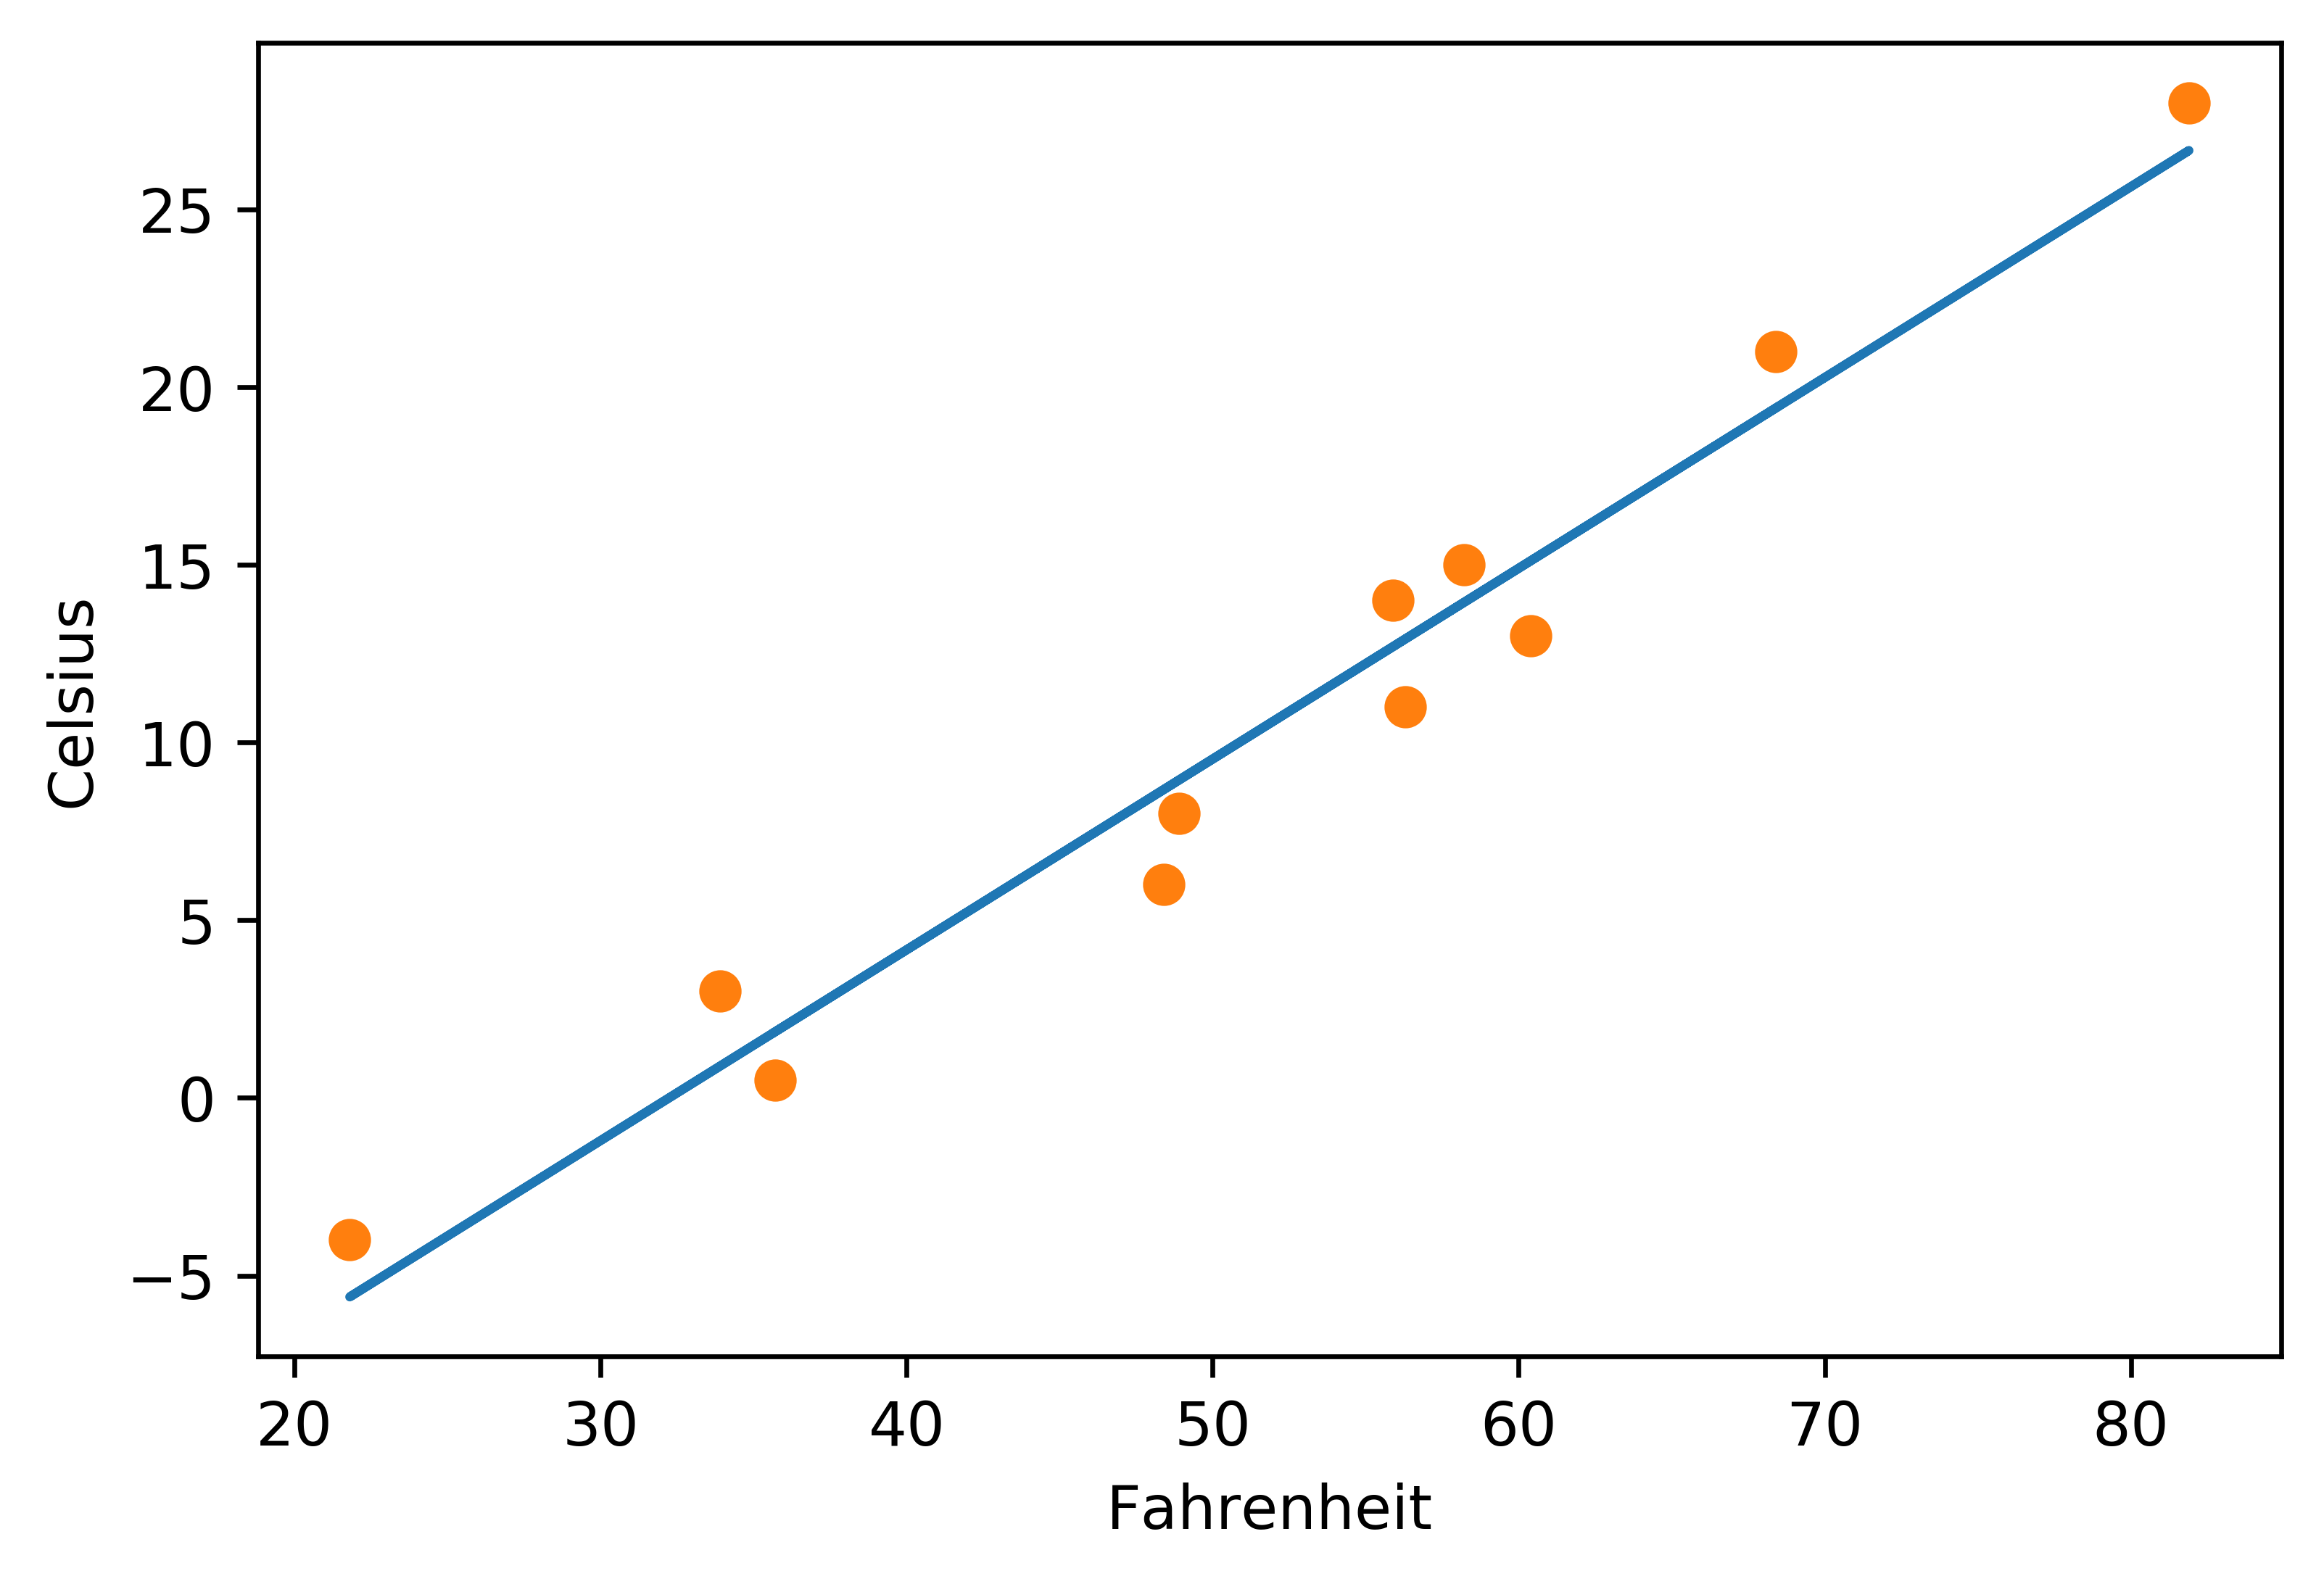

In [31]:
from matplotlib import pyplot as plt
t_p = model(t_un, *params)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

上图显示，直线是比较适合用来拟合这部分数据的，这里需要强调作图很重要，可以让你更加直观地观察数据规律。

# PyTorch's autograd: Backpropagate all things

上一节我们用最基本的方法走了一遍参数更新的过程，但是很显然这种手写的过程有很多弊端，比如说模型过于复杂，参数量过大的时候，手写每个参数的梯度就不太现实。

`pytorch`为我们提供了便捷的操作，有一个属性叫做`autograd`，`pytorch`的`tensor`可以记住它来自的式子和产生它的`tensor`，自动进行求导，我们下面会详细描述：

In [1]:
import torch
import numpy as np

#摄氏度下的温度数据
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]

#与上面对应的另一个单位的温度数据
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]


#将以上数据转成tensor形式
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_un = 0.1 * t_u

In [5]:
#上一节的模型
def model(t_u, w, b):
    return w * t_u + b

In [6]:
#上一节的损失函数
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [4]:
#初始化参数
#这里requires_grad表示参数需要求梯度
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [5]:
params.grad is None    #参数会进行求梯度

True

有了`grad`这个工具，我们就可以很方便的进行上一节的操作：
- call the model
- computer the loss
- call backward on the loss

In [7]:
t_p = model(t_u, *params)     # call the model
loss = loss_fn(t_p, t_c)     # computer the loss
loss.backward()              # call backward on the loss

In [8]:
params.grad      # 这个求出来的是params对于loss的梯度

tensor([4517.2969,   82.6000])

In [9]:
params          # 因为还没有进行更新参数操作，所以参数params并没有改变

tensor([1., 0.], requires_grad=True)

**重要**  接下来我们介绍一个`grad`重要的特征：`积累性`。下面我们将上面的代码原封不动的运行了一遍，按道理应该和上面结果一样，但是我们发现`grad`的值不一样，而且是两倍的关系，这是因为`pytorch`设计时，参数的`grad`属性具有积累性，一旦运行，所求的的梯度会一直保存在`grad`里面，不会自动清0，这样的话需要我们自己手动清0，这种设计方法其实是有好处的，可以更加灵活使用。

In [10]:
t_p = model(t_u, *params)     # call the model
loss = loss_fn(t_p, t_c)     # computer the loss
loss.backward()              # call backward on the loss
params.grad      # 这个求出来的是params对于loss的梯度

tensor([9034.5938,  165.2000])

我们可以这么改，手动清0：

In [11]:
t_p = model(t_u, *params)     # call the model
loss = loss_fn(t_p, t_c)     # computer the loss
if params.grad is not None:
    params.grad.zero_()
    loss.backward()              # call backward on the loss
params.grad      # 这个求出来的是params对于loss的梯度

tensor([4517.2969,   82.6000])

OK，说了这么多，我们可以书写我们的`training_loop`函数了：

In [13]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        if params.grad is not None: 
            params.grad.zero_()            # grad清0
        
        t_p = model(t_u, *params)         # call the model
        loss = loss_fn(t_p, t_c)        #computer the loss
        loss.backward()                  #call backward on the loss
        
        params = (params - learning_rate * params.grad).detach().requires_grad_()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

上面可能比较有疑惑的是那个`.detach().requires_grad_()`的操作，我们解释一下：
- 首先detach()方法的作用是从当前计算图上复制一个新的变量tensor，与原变量享有同一个内存空间，但是返回的值不具有grad属性
- requires_grad_()带下划线的方法表示进行的操作in_place掉原来的变量

那么那样做的目的其实也很明显，如果不做的话每次会生成一个`params`，存在不同的空间中，导致`backpropagation`的时候引起错乱。

ok ,接下来我们训练一下看看：

In [15]:
training_loop(n_epochs=5000, learning_rate=1e-2, params=torch.tensor([1.0, 0.0], requires_grad=True), t_u=t_un, t_c=t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

我们得到了和之前一样的结果，虽然我们可以手动求导，但是有了pytorch，我们再也不用这么做了。

## 优化算法

上面我们用到的是`gradient descent`来优化，那么还有哪些优化算法吗，我们接下来开始介绍。

`pytorch`有一个`optim`模块，里面提供了很多优化算法。

In [7]:
import torch.optim as optim

In [17]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

创建一个`SGD(Stochastic Gradient Descent)`优化器：

In [18]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()    #对应于上面参数更新过程

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

当`step()`被调用时，`params`更新一次，上面还缺好一个最重要的步骤，也就是上面所说的积累效应，使用更新操作时，应该确保参数梯度为0

In [19]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()    #对应于上面参数更新过程

params

tensor([1.7761, 0.1064], requires_grad=True)

对应的`training_loop()`应该做如下修改：

In [20]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        t_p = model(t_u, *params)         # call the model
        loss = loss_fn(t_p, t_c)        #computer the loss
        
        optimizer.zero_grad()
        loss.backward()                  #call backward on the loss
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [21]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs=5000, optimizer=optimizer, params=params, t_u=t_un, t_c=t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

我们还可以尝试很多种优化方法，比如说`Adam`,Adam有很多优点，比如：
- learning rate可以自适应的设置
- 对参数缩放的敏感度低很多，我们可以直接使用t_u

In [22]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs=5000, optimizer=optimizer, params=params, t_u=t_u, t_c=t_c)

Epoch 500, Loss 7.612903
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646
Epoch 2500, Loss 2.927646
Epoch 3000, Loss 2.927645
Epoch 3500, Loss 2.927647
Epoch 4000, Loss 2.927645
Epoch 4500, Loss 2.927646
Epoch 5000, Loss 2.927646


tensor([  0.5368, -17.3048], requires_grad=True)

到目前为止，我们学会了**搭建模型**，**计算损失函数**，**backward**，**优化参数**等等，接下来我们介绍如何训练。验证以及训练中常见问题。

## training, validation and overfitting

上一节介绍了如何优化模型，这一节我们介绍训练模型时常见的问题

通常情况下，我们将数据划分成训练集和验证集，训练集用来训练模型，验证集用来验证模型的好坏。我们会出现模型在训练集上loss下降，但是验证集上不下降的情况，这种情况就叫做`overfitting`

一般可能的原因是模型足够大，参数够多，导致对于训练集的学习过了，本质上并没有学到真正有用的特征。

对于`overfitting`，有以下的`rule`：
- 如果训练误差不下降，可能是因为模型对于数据来说太简单，或者是数据本身存在问题，不包含有用的信息
- 如果训练误差和验证误差不一样，那么就存在过拟合现象

解决`overfitting`的方法:
1. 确保你有足够的数据进行训练
2. 假设你有足够的数据了，那你应该保证模型在数据点之间是规则的，可以通过以下方法实现：
      - 给`loss function`添加惩罚项
      - 给输入数据添加噪声，人工创造新的数据让模型拟合


接下来我们实现将数据集划分成训练集和验证集的过程：

In [2]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)       #这句话的意思是数据集的20%用作验证集，80%用作训练集

shuffled_indices = torch.randperm(n_samples) #randperm返回一个打乱的索引列表

train_indices = shuffled_indices[:-n_val]       #取打乱的索引列表前80%作为训练集
val_indices = shuffled_indices[-n_val:]         #取打乱的后20%作为测试集

train_indices, val_indices

(tensor([ 2,  6,  7,  3,  0, 10,  1,  8,  9]), tensor([5, 4]))

In [3]:
#我们根据得到的索引来获取数值
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u    #对测试集中的数据进行缩放
val_t_un = 0.1 * val_t_u        #对验证集中的数据进行缩放

数据已经准备好了，我们开始写`training_loop`函数：

In [4]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs+1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, float(train_loss), float(val_loss)))
            
    return params

In [8]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)       #使用SGD时，需要使用归一化的输入

training_loop(n_epochs=3000, optimizer=optimizer, params=params, train_t_u=train_t_un, val_t_u=val_t_un, train_t_c=train_t_c, val_t_c=val_t_c)

Epoch 1, Training loss 93.94430541992188, Validation loss 19.254497528076172
Epoch 2, Training loss 43.22986602783203, Validation loss 0.7752135396003723
Epoch 3, Training loss 35.536163330078125, Validation loss 4.8714165687561035
Epoch 500, Training loss 7.103917598724365, Validation loss 5.2107954025268555
Epoch 1000, Training loss 3.509843587875366, Validation loss 3.8908233642578125
Epoch 1500, Training loss 3.039865493774414, Validation loss 3.5030860900878906
Epoch 2000, Training loss 2.9784064292907715, Validation loss 3.374584674835205
Epoch 2500, Training loss 2.970371961593628, Validation loss 3.3296408653259277
Epoch 3000, Training loss 2.9693217277526855, Validation loss 3.3135972023010254


tensor([  5.3838, -17.0660], requires_grad=True)

上面我们可以看到`training loss`和`validation loss`都呈现下降趋势，所以我们很好地控制住了`overfitting`.

## Nits in autograd and switching it off

以上`training loop` 里面我们形成了两个计算图，一个是`train_t_u-->train_t_p-->train_loss`, 另一个是`val_t_u-->val_t_p-->val_loss`。这两个计算图只有在`params`处是相同的，我们对`train_loss`进行`backward`操作,可能会导致`val_loss`也记录导数积累信息，所以这里我们使用`no_grad()`来消除`val_loss`的梯度积累:

In [9]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs+1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, float(train_loss), float(val_loss)))
            
    return params

In [10]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)       #使用SGD时，需要使用归一化的输入

training_loop(n_epochs=3000, optimizer=optimizer, params=params, train_t_u=train_t_un, val_t_u=val_t_un, train_t_c=train_t_c, val_t_c=val_t_c)

Epoch 1, Training loss 93.94430541992188, Validation loss 19.254497528076172
Epoch 2, Training loss 43.22986602783203, Validation loss 0.7752135396003723
Epoch 3, Training loss 35.536163330078125, Validation loss 4.8714165687561035
Epoch 500, Training loss 7.103917598724365, Validation loss 5.2107954025268555
Epoch 1000, Training loss 3.509843587875366, Validation loss 3.8908233642578125
Epoch 1500, Training loss 3.039865493774414, Validation loss 3.5030860900878906
Epoch 2000, Training loss 2.9784064292907715, Validation loss 3.374584674835205
Epoch 2500, Training loss 2.970371961593628, Validation loss 3.3296408653259277
Epoch 3000, Training loss 2.9693217277526855, Validation loss 3.3135972023010254


tensor([  5.3838, -17.0660], requires_grad=True)

我们也可以写一个函数，控制`forward`过程是否计算梯度，这里我们提供一个`calc_forward()`函数：

In [11]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

我们使用`calc_forward()`函数来改写`training_loop()`函数：

In [15]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs+1):
        
        train_loss = calc_forward(train_t_u, train_t_c, True)     #train的过程需要计算梯度，所以is_train=True
        #train_t_p = model(train_t_u, *params)
        #train_loss = loss_fn(train_t_p, train_t_c)
        
        val_loss = calc_forward(val_t_u, val_t_c, False)     #validation的过程不需要计算梯度，所以is_train=False
        #val_t_p = model(val_t_u, *params)
        #val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, float(train_loss), float(val_loss)))
            
    return params

In [16]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)       #使用SGD时，需要使用归一化的输入

training_loop(n_epochs=3000, optimizer=optimizer, params=params, train_t_u=train_t_un, val_t_u=val_t_un, train_t_c=train_t_c, val_t_c=val_t_c)

Epoch 1, Training loss 93.94430541992188, Validation loss 19.254497528076172
Epoch 2, Training loss 43.22986602783203, Validation loss 0.7752135396003723
Epoch 3, Training loss 35.536163330078125, Validation loss 4.8714165687561035
Epoch 500, Training loss 7.103917598724365, Validation loss 5.2107954025268555
Epoch 1000, Training loss 3.509843587875366, Validation loss 3.8908233642578125
Epoch 1500, Training loss 3.039865493774414, Validation loss 3.5030860900878906
Epoch 2000, Training loss 2.9784064292907715, Validation loss 3.374584674835205
Epoch 2500, Training loss 2.970371961593628, Validation loss 3.3296408653259277
Epoch 3000, Training loss 2.9693217277526855, Validation loss 3.3135972023010254


tensor([  5.3838, -17.0660], requires_grad=True)